# A bead-spring model with $N=2$

In this notebook, we introduce the way how to use the CNEEP for estimating the EP or for quantifying the dissipation map from the movies.

In [1]:
import sys

sys.path.append('..')

In [2]:
from argparse import Namespace

import numpy as np
from scipy import stats
import torch
import torch.nn as nn

from misc.sampler import CartesianSampler, CartesianSeqSampler
from toy.bead_spring import del_medium_etpy, del_shannon_etpy, simulation, p_ss

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from IPython.display import display, clear_output, HTML, Image
from matplotlib import animation, rc
Writer = animation.writers['pillow']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['text.usetex'] = False
# csfont = {'fontname':'Times New Roman'}
plt.rcParams['font.family'] = 'Helvetica-light'



## CNEEP Architecture

In [3]:
class CNEEP(nn.Module):
    def __init__(self, opt):
        super(CNEEP, self).__init__()
        self.n_layer = opt.n_layer
        self.init_channel = opt.n_channel
        
        # conv layers
        tmp = nn.Sequential()
        tmp.add_module("conv", nn.Conv2d(opt.seq_len, opt.n_channel, kernel_size=5, stride=2, padding=2))
        tmp.add_module("relu", nn.ReLU(inplace=True))
        tmp.add_module("maxpool", nn.MaxPool2d(kernel_size=2, stride=2))
        setattr(self, "layer1", tmp)
        for i in range(opt.n_layer-1):
            tmp = nn.Sequential()
            tmp.add_module("conv1", nn.Conv2d(opt.n_channel * (2**i), opt.n_channel * (2**i), kernel_size=3, stride=1, padding=1))
            tmp.add_module("relu1", nn.ReLU(inplace=True))
            tmp.add_module("conv2", nn.Conv2d(opt.n_channel * (2**i), opt.n_channel * (2**(i+1)), kernel_size=3, stride=1, padding=1))
            tmp.add_module("relu2", nn.ReLU(inplace=True))
            
            if i < opt.n_layer-2:
                tmp.add_module("maxpool", nn.MaxPool2d(kernel_size=2, stride=2))
            setattr(self, "layer%d" % (i + 2), tmp)

        # fc layers
        tempH, tempW = opt.input_shape
        self.fc1 = nn.Linear(opt.n_channel * (2**(opt.n_layer-1)) * ((tempH+1)//(2**(2 + opt.n_layer-2))) * ((tempW+1)//(2**(2 + opt.n_layer-2))), 1, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.out = nn.Sequential(
            self.fc1,
        )

        # initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x_ = x
        _x = torch.flip(x, [1])

        for i in range(self.n_layer):
            f = getattr(self, "layer%d" % (i + 1))
            x_ = f(x_)
        x_ = x_.view(x_.size(0), -1)   # Flatten them for FC layers
        out_f = self.out(x_)
        
        for i in range(self.n_layer):
            f = getattr(self, "layer%d" % (i + 1))
            _x = f(_x)
        _x = _x.view(_x.size(0), -1)   # Flatten them for FC layers
        out_r = self.out(_x)
        
        return out_f - out_r
    

## Training Algorithm

In [4]:
def train(opt, model, optim, trajs, sampler, transform):
    model.train()
    batch = next(sampler)
    
    x = transform(torch.cat([trajs[(batch[0], batch[1][i])] for i in range(opt.seq_len)], dim=1).float().to(opt.device))
    ent_production = model(x)
    optim.zero_grad()
    
    # The objective function J. Equation (2)
    loss = (-ent_production + torch.exp(-ent_production)).mean()
    loss.backward()
    optim.step()
    return loss.item()


def validate(opt, model, trajs, sampler, transform):
    model.eval()

    ret = []
    loss = 0
    with torch.no_grad():
        for batch in sampler:
            x = transform(torch.cat([trajs[(batch[0], batch[1][i])] for i in range(opt.seq_len)], dim=1).float().to(opt.device))
            
            ent_production = model(x)
            entropy = ent_production.cpu().squeeze().numpy()
            ret.append(entropy)
            loss += (- ent_production + torch.exp(-ent_production)).sum().cpu().item()
    loss = loss / sampler.size
    ret = np.concatenate(ret)
    ret = ret.reshape(trajs.shape[0], -1)
    return ret, loss


## Hyper-parameters

In [5]:
opt = Namespace()
opt.device = 'cuda:0' 
opt.batch_size = 1024
opt.test_batch_size = 2000
opt.n_hidden = 512

opt.lr = 0.0001
opt.wd = 1e-5

opt.record_freq = 1000
opt.seed = 3       # In our paper, we used the seed numbers from 1 to 5 for five independent estimators.

opt.n_layer = 2
opt.n_channel = 32

opt.input_shape = (20, 40)     # the shape of images
opt.M = 100         # number of trajectories
opt.L = 10000        # lenth of a trjectory 
opt.seq_len = 2      # length of consecutive transitions for inputs (see the section 'incomplete scenarios')
opt.Tc = 1            # cold temperature
opt.Th = 10           # hot temperature 
opt.time_step = 0.01  # time step size for Langevin simulation

torch.manual_seed(opt.seed)

## Load bead-spring movies with $N=2$

In [6]:
train_imgs = np.load("../data/beads_2/train/img_2beads_1.0_(%d, %d).npy" %(opt.Tc, opt.Th))
trajs_np = np.load("../data/beads_2/train/trj_2beads_0_(%d, %d).npy" %(opt.Tc, opt.Th))
train_imgs_t = torch.from_numpy(train_imgs).float().reshape((opt.M, opt.L, 1, 20, 40))
trajs_t = torch.from_numpy(trajs_np).float()

# Here, a test dataset is used to check how well the estimator trains 
test_imgs = np.load("../data/beads_2/test/img_2beads_1.0_(%d, %d).npy" %(opt.Tc, opt.Th))
test_trajs_np = np.load("../data/beads_2/test/trj_2beads_0_(%d, %d).npy" %(opt.Tc, opt.Th))
test_imgs_t = torch.from_numpy(test_imgs).float().reshape((opt.M, opt.L, 1, 20, 40))
test_trajs_t = torch.from_numpy(test_trajs_np).float()

print("A shape of train_imgs_t (test_imgs_t) (opt.M, opt.L, 1 (channel), width, height): ", train_imgs_t.shape)
print("A shape of trajs_t (test_trajs_t) (opt.M, opt.L, # of beads): ", train_imgs_t.shape)

A shape of train_imgs_t (test_imgs_t) (opt.M, opt.L, 1 (channel), width, height):  torch.Size([100, 10000, 1, 20, 40])
A shape of trajs_t (test_trajs_t) (opt.M, opt.L, # of beads):  torch.Size([100, 10000, 1, 20, 40])


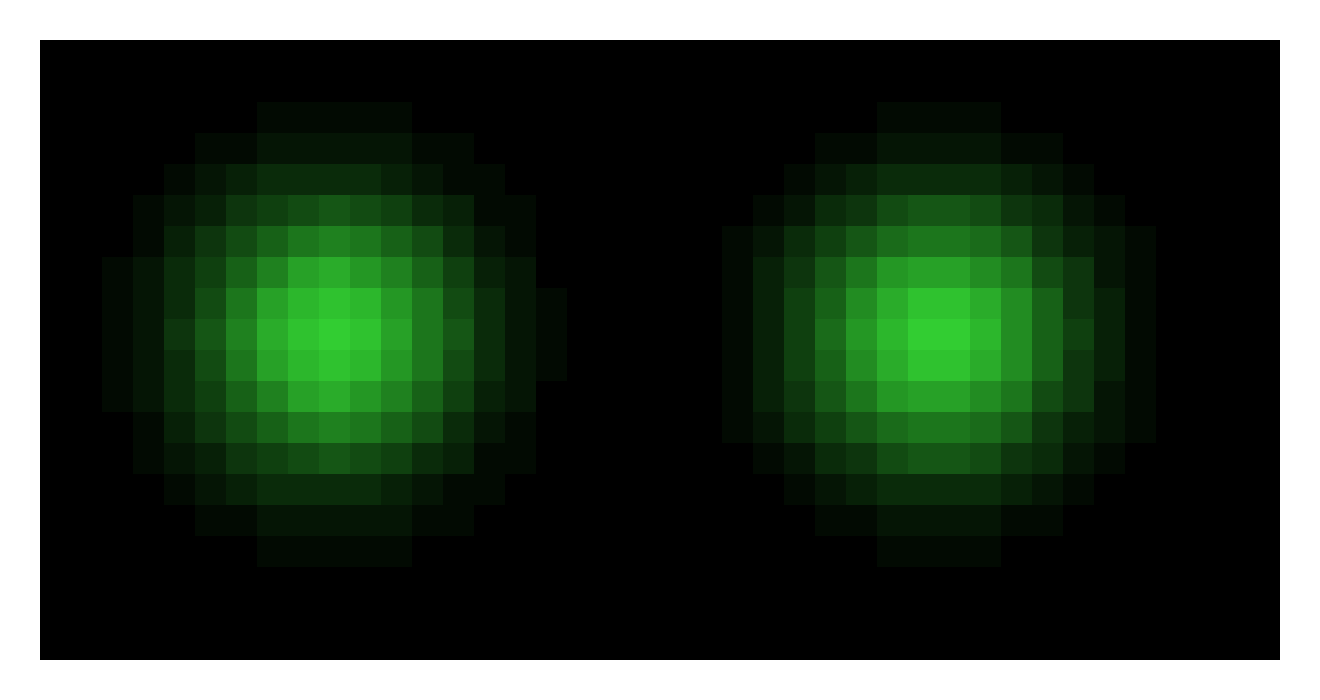

In [7]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), dpi=200)
plt.axis('off')

frame_length = 1000

img = ax1.imshow(train_imgs[0][0].astype(np.float32)/255, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                                    ['black','limegreen'], 20), 
                   vmin=0, vmax=1, extent=[0, 2, 0, 1], origin ='lower')



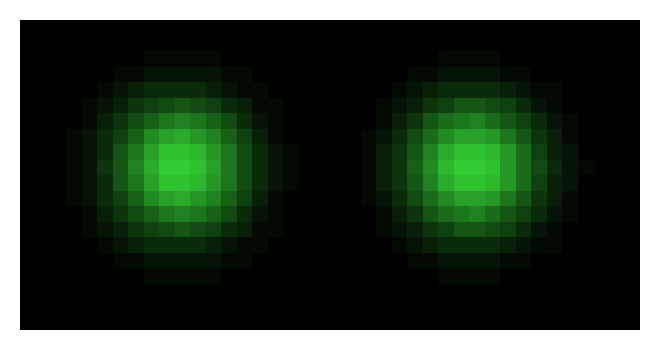

In [8]:
def update_graph(i):
    draw_frame.set_data(frames[:i])
    
def animate(i): 
    img.set_data(train_imgs[0][i].astype(np.float32)/255)
    return (img,)

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), dpi=100)
plt.axis('off')

frame_length = 1000

img = ax1.imshow(train_imgs[0][0].astype(np.float32)/255, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                                    ['black','limegreen'], 20), 
                   vmin=0, vmax=1, extent=[0, 2, 0, 1], origin ='lower')

anim = animation.FuncAnimation(fig1, animate, frames=frame_length, interval=50, blit=True)
HTML(anim.to_html5_video())


## Let's build our model!

In [8]:
# The pixel values in the loaded images range from 0 to 255 integers, so we rescale them from -1 to 1 for training.
mean, std = train_imgs[0][0].mean(), train_imgs[0][0].std()
transform = lambda x: (x - mean)/std

# Build the model
model = CNEEP(opt)
model = model.to(opt.device)
optim = torch.optim.Adam(model.parameters(), opt.lr, weight_decay=opt.wd)
    
train_sampler = CartesianSeqSampler(opt.M, opt.L, opt.seq_len, opt.test_batch_size, device=opt.device)
test_sampler = CartesianSeqSampler(opt.M, opt.L, opt.seq_len, opt.test_batch_size, device=opt.device, train=False)


In [9]:
# A function for a scatter plot between true EPs and estimations.
def plot_scatter(pred, ent, save_path=None, trained=False):
    pred_rate, _, r_value, pvalue, _  = stats.linregress(ent, pred)
    plt.figure(figsize=(3,3), dpi=100)
    sns.regplot(ent, pred,
                color='C3', 
                line_kws={
                    'lw':2.0,
                    'label':'$R^2=$ %.4f' %(r_value**2)},
                scatter_kws={
                    'color':'grey', 
                    'alpha':0.03, 
                    's':3, 
                    'rasterized':True})
    plt.xlabel('$\Delta S$', fontsize=25)
    plt.ylabel('$\Delta S_{\\theta}$', fontsize=25)
    plt.xticks([-2, 0, 2], fontsize=20)
    if trained:
        plt.yticks([-2, 0, 2], fontsize=20)
    else:
        plt.yticks([-0.05, 0, 0.05], fontsize=20)
    plt.legend(loc="upper center", fontsize=15, frameon = False)
    
    if save_path is not None:
        plt.savefig(save_path)

In [10]:
preds_untrained, _ = validate(opt, model, train_imgs_t, test_sampler, transform)

# Analytic EP
ents = del_medium_etpy(trajs_t, 1, 10) + del_shannon_etpy(trajs_t, 1, 10)

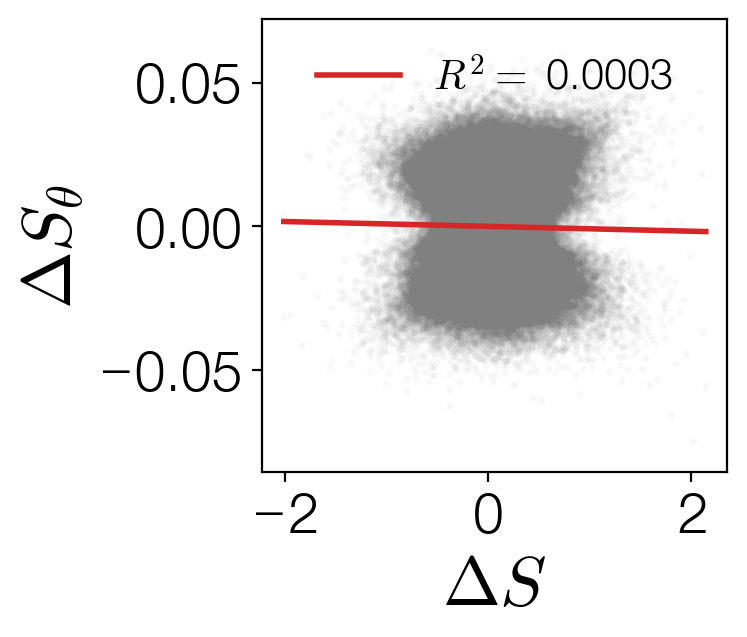

In [16]:
# A scatter plot before training the CNEEP

plot_scatter(preds_untrained.flatten(), ents.numpy().flatten())

## Training process

This is the process for training the estimator (the detailed algorithm is written in Supplemental material).
For the convenience, we just use the estimator's parameter $\theta$ obtained at the end of training.
Of course, for the best performance, it would be better to use the $\theta$ at the optimal loss by checking the loss values w.r.t. training iterations as written in Supplementary Material; please check 'BeadSpring.py' for the python code.


In [17]:
opt.n_iter = 20000    # number of training iteration

for i in tqdm(range(1, opt.n_iter + 1)):
    train(opt, model, optim, train_imgs_t, train_sampler, transform)


#### If you have no time for waiting until the training completed, you can load the parameter we prepared :)

In [11]:
model.load_state_dict(torch.load("../results/2BS/T_1/L_10000/seed3/model_best.pth.tar")['state_dict'])


<All keys matched successfully>

In [12]:
preds, _ = validate(opt, model, train_imgs_t, test_sampler, transform)


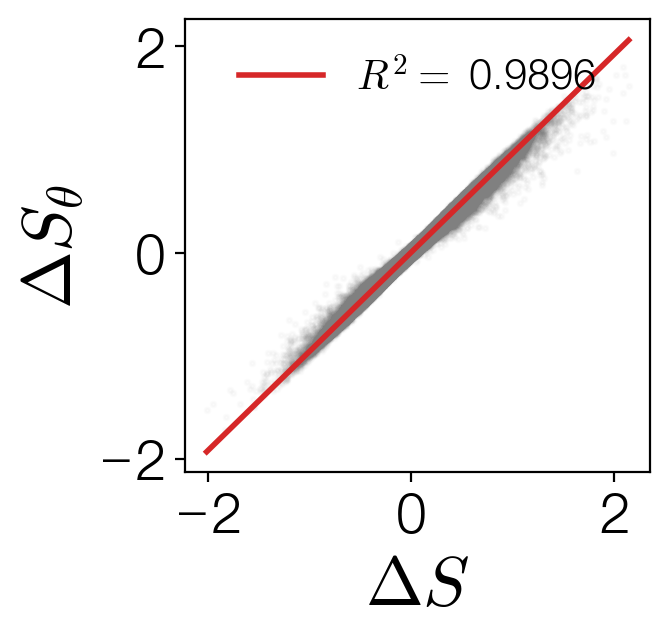

In [23]:
# A scatter plot after training the CNEEP

plot_scatter(preds.flatten(), ents.numpy().flatten(), trained=True)

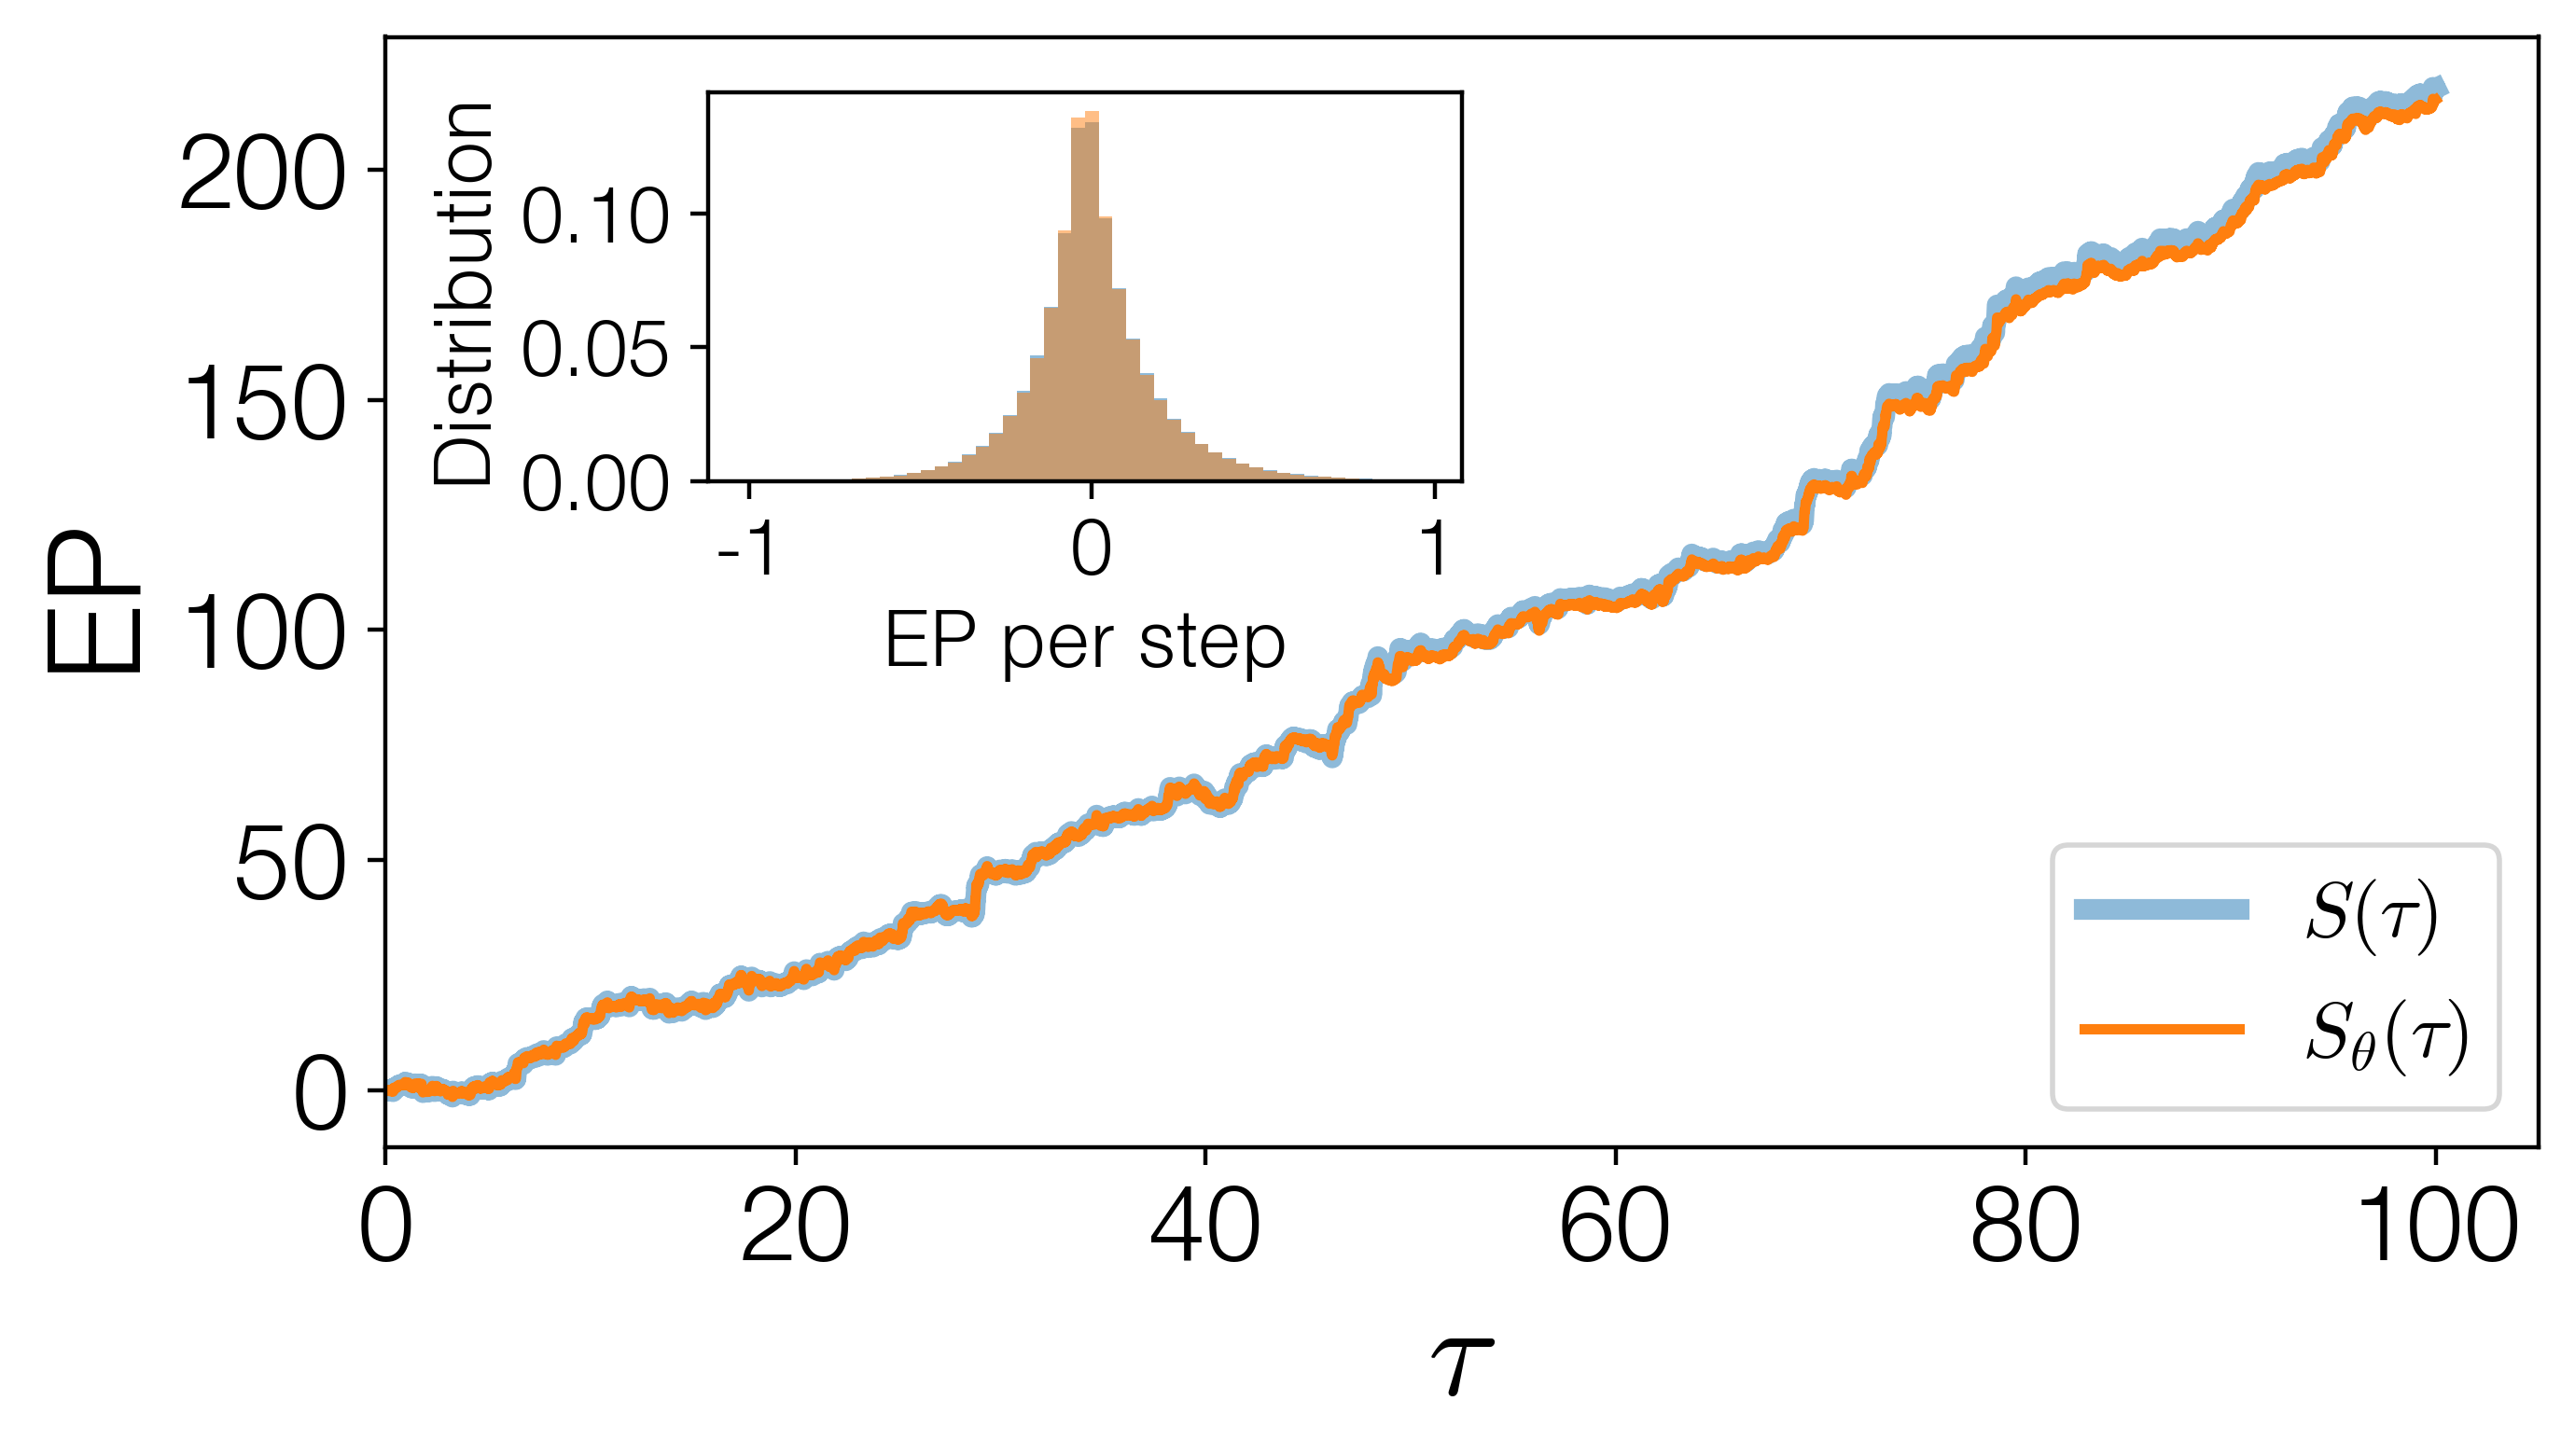

In [13]:
idx = 13 #np.random.randint(0, 1000)

ent = ents[idx]
pred = preds[idx]

cum_preds = np.cumsum(preds, axis=1)
cum_ents = np.cumsum(ents, axis=1)

taus = np.linspace(0, opt.L * opt.time_step, num=opt.L - 1)

plt.figure(figsize=(7, 4), dpi=200)
plt.plot(taus, np.cumsum(ent), lw=4, alpha=0.5,color='C0', 
         label='$S(\\tau)$')
plt.plot(taus, np.cumsum(pred), lw=2, color='C1',
         label='$S_{\\theta}(\\tau)$')
# plt.plot([], ls = 'dotted', color='C0', lw=2, 
#          label='$\sigma(\\tau)$')
# plt.plot([], lw=2, ls = '--', alpha=0.5, color='C1',
#          label='$\sigma_{\\theta}(\\tau)$')

plt.xlim(0)
plt.xlabel('$\\tau$', fontsize=25)
plt.ylabel(r'EP', fontsize=25)

plt.xticks([0, 20, 40, 60, 80, 100], fontsize=20)
plt.yticks([0, 50, 100, 150, 200], fontsize=20)

plt.legend(loc='lower right', frameon = True, fontsize=15)
ax = plt.gca()

axins = ax.inset_axes([0.15, 0.60, 0.35, 0.35])

values, bins = np.histogram(ents.flatten(), bins=50, range=(-1, 1))
values = values/np.sum(values)

axins.bar(bins[:-1], values, alpha=0.5, width=bins[:-1]-bins[1:])

values, bins = np.histogram(preds.flatten(), bins=50, range=(-1, 1))
values = values/np.sum(values)

axins.bar(bins[:-1], values, alpha=0.5, width=bins[:-1]-bins[1:])
axins.set_xlabel(r'EP per step', fontsize=15)
axins.set_ylabel(r'Distribution', fontsize=15)
axins.set_xticks([-1, 0, 1])
axins.set_yticks([0.00, 0.05, 0.10])
axins.set_xticklabels(labels=['-1', '0', '1'], fontsize=15)
axins.set_yticklabels(labels=['0.00', '0.05', '0.10'], fontsize=15)

plt.tight_layout()

## Dissipation map for the bead-spring model with $N=2$

Here, we introduce how we extract the dissipation map using weights of the last convolutional layer.

In [14]:
# To save the attention map, we register the hook which append the attention map to 'feature_results' at the convolutional layer of our model.

feature_results = []

hooks = []
def hook_feature(module, input, output):
    feature_results.append(output.cpu().detach().numpy())

print(len(hooks))
hooks.append(model._modules.get('layer2').register_forward_hook(hook_feature))

0


### First, we check the dissipation map $\mathcal{H}(x, y)$ along a movie, representing where and how much EP occurs at each time step.

In [15]:
train_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.test_batch_size, device=opt.device)
test_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.test_batch_size, device=opt.device, train=False)

params = list(model.parameters())
weight = np.squeeze(params[-2].cpu().data.numpy())    # the weight of the last layer, $w_c$ in the paper.

feature_results = []

preds = validate(opt, model, train_imgs_t[:1], test_sampler, transform)
feature_shape = feature_results[0][0][0].shape     # the shape of the attention map $ \mathcal{H}(x, y)$

map_f = weight * feature_results[0].reshape((opt.test_batch_size, -1))   # Eq.(4) in the paper for a forward transition.
map_f = map_f.reshape(opt.test_batch_size, 64, feature_shape[0], feature_shape[1]).sum(axis=1)

map_r = weight * feature_results[1].reshape((opt.test_batch_size, -1))   # Eq.(4) in the paper for a backward transition.
map_r = map_r.reshape(opt.test_batch_size, 64, feature_shape[0], feature_shape[1]).sum(axis=1)

final_map = map_f-map_r

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


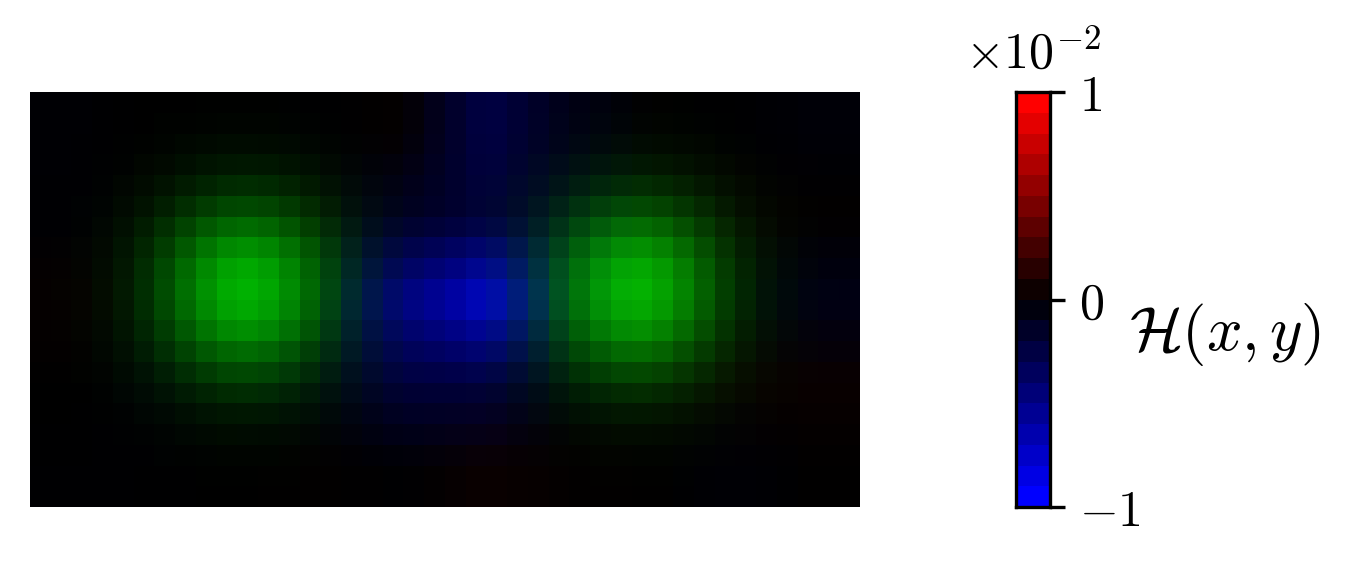

In [16]:
import cv2
from matplotlib import gridspec

frame_length = 1000

fig1 = plt.figure(figsize=(5, 2), dpi=150)
gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[25, 1])

# these codes are for a colorbar
ax2 = plt.subplot(gs[1])
cbar = np.linspace(0, 1, 20).reshape((20, 1))
ax2.imshow(cbar, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue', 'black','red'], 20), 
                 vmin=0, vmax=1, extent=[0, 0.5, 0, 6], origin ='lower')
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
ax2.yaxis.tick_right()
ax2.set_yticks([0, 3, 6])
ax2.set_yticklabels([r'$-1$', r'$0$', r'$1$'], fontsize=12)
plt.title(r'$\times 10^{-2}$')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$\mathcal{H}(x, y)$', rotation='horizontal', fontsize=15, labelpad=20)


# these codes are for a dissipation map along a movie.
ax1 = plt.subplot(gs[0])
pos_epmap = np.zeros(final_map.shape)
pos_epmap[final_map > 0] = final_map[final_map > 0]

neg_epmap = np.zeros(final_map.shape)
neg_epmap[final_map < 0] = final_map[final_map < 0]

dst1 = np.zeros((frame_length, opt.input_shape[0], opt.input_shape[1], 3))
dst2 = np.zeros((frame_length, opt.input_shape[0]//4, opt.input_shape[1]//4, 3))

dst1[:, :, :, 1] = 0.7 * train_imgs[0][:frame_length].astype(np.float)/255   # green
dst2[:, :, :, 0] = pos_epmap[:frame_length] * 100      # red
dst2[:, :, :, 2] = -neg_epmap[:frame_length] * 100     # blue

dst = dst1[0] + cv2.resize(dst2[0], (opt.input_shape[1], opt.input_shape[0]))/16


img1 = ax1.imshow(dst, extent=[0, 2, 0, 1], origin ='lower')
plt.axis('off')
plt.tight_layout()

def animate(i):
    img1.set_data(dst1[i] + cv2.resize(dst2[i], (opt.input_shape[1], opt.input_shape[0]))/16)
    
    return (img1,)

anim = animation.FuncAnimation(fig1, animate, frames=frame_length, interval=50, blit=True)
HTML(anim.to_html5_video())


### Second, we check the averaged dissipation map $\langle \dot{\mathcal{H}} (x, y) \rangle$ over movies.

In [19]:
train_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.test_batch_size, device=opt.device)
test_sampler = CartesianSeqSampler(1, opt.L, opt.seq_len, opt.test_batch_size, device=opt.device, train=False)

params = list(model.parameters())
weight = np.squeeze(params[-2].cpu().data.numpy())       # the weight of the last layer, $w_c$ in the paper.

# Average over M movies
for j in tqdm(range(opt.M)):
    feature_results = []
    
    preds = validate(opt, model, train_imgs_t[j:j+1], test_sampler, transform)
    feature_shape = feature_results[0][0][0].shape
    
    for i in range(1+(opt.L-1)//opt.test_batch_size):
        steps = opt.test_batch_size if i < (opt.L-1)//opt.test_batch_size else (opt.L-1)%opt.test_batch_size

        map_f = weight * feature_results[2*i].reshape((steps, -1))
        map_f = map_f.reshape(steps, 64, feature_shape[0], feature_shape[1]).sum(axis=1)

        map_r = weight * feature_results[2*i+1].reshape((steps, -1))
        map_r = map_r.reshape(steps, 64, feature_shape[0], feature_shape[1]).sum(axis=1)

        if i == 0:
            final_map = map_f-map_r

        else:
            final_map = np.concatenate((final_map, map_f-map_r), axis=0)
            
    if j == 0:
        dissp_map = np.mean(final_map, axis=0)
        
    else:
        dissp_map += np.mean(final_map, axis=0)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sum of the averaged dissipation map:  1.9896728


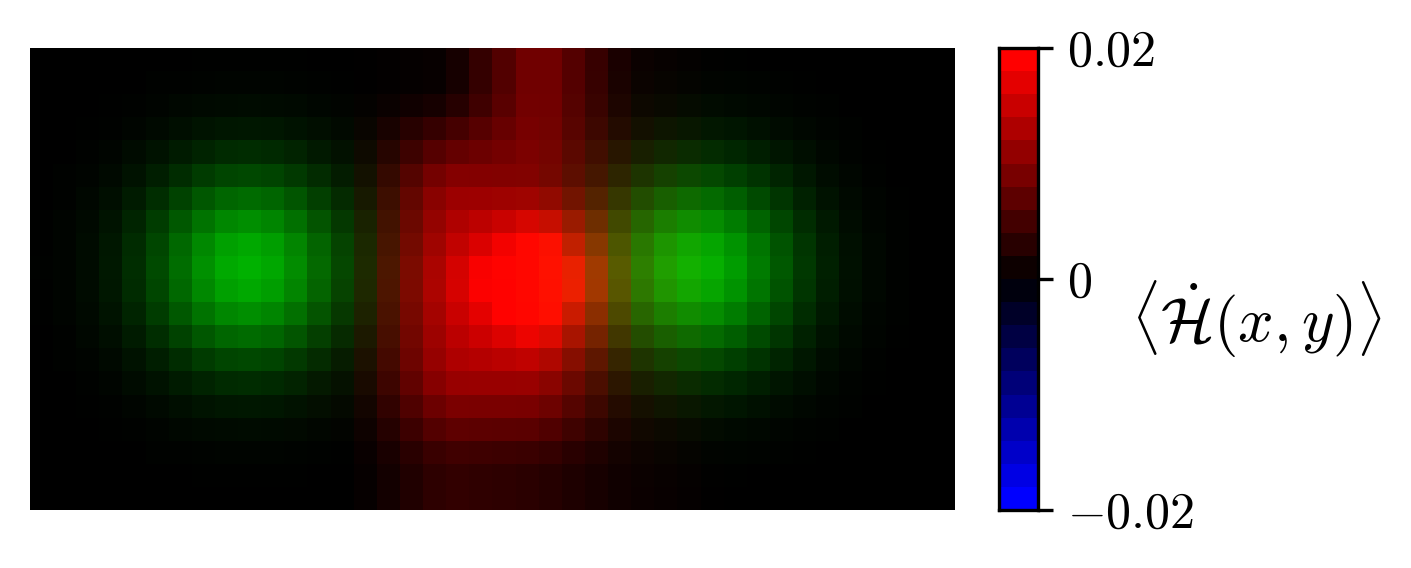

In [20]:
idx = 0

fig1 = plt.figure(figsize=(5, 2), dpi=150)
gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[25, 1])

# these codes are for a colorbar
ax2 = plt.subplot(gs[1])
cbar = np.linspace(0, 1, 20).reshape((20, 1))
ax2.imshow(cbar, cmap= mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue', 'black','red'], 20), 
                 vmin=0, vmax=1, extent=[0, 0.5, 0, 6], origin ='lower')
plt.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
ax2.yaxis.tick_right()
ax2.set_yticks([0, 3, 6])
ax2.set_yticklabels([r'$-0.02$', r'$0$', r'$0.02$'], fontsize=12)
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$\langle \dot{\mathcal{H}}(x, y) \rangle$', rotation='horizontal', fontsize=15, labelpad=15)

# these codes are for a dissipation map along a movie.
ax1 = plt.subplot(gs[0])
dst2 = np.zeros((opt.input_shape[0]//4, opt.input_shape[1]//4, 3))

dst2[:, :, 0] = dissp_map * 50      # red
dst2[:, :, 2] = -dissp_map * 50     # blue

dst = dst1[idx] + cv2.resize(dst2, (opt.input_shape[1], opt.input_shape[0]))/(16)

img1 = ax1.imshow(dst, extent=[0, 2, 0, 1], origin ='lower')
plt.axis('off')
plt.tight_layout()

print(r"Sum of the averaged dissipation map: ", np.sum(dissp_map))